In [1]:
%matplotlib inline
import pandas as pd, matplotlib.pyplot as plt
import seaborn as sn, mpld3, numpy as np
from datetime import timedelta

sn.set_context('notebook')

# UV absorbance sensor data

Kari has two UV absorbance datasets:

 1. A weekly dataset based on water samples collected and analysed in the lab. <br><br>
 
 2. A high frequency dataset based on telemetered, in-situ monitoring. This series initially has two-day temporal resolution, but more recently the measurements are taken approximately every two hours.
 
The probes operate across a wide range of frequencies, from wavelengths of around 190 nm to 360 nm (at intervals of ~1 nm). They therefore generate a large volume of data.

The high frequency series have a number of data gaps, and also show a steady "**drift**" with time compared to the lab measurements. The aim of this notebook is to explore the two datasets to get a feel for how difficult they are to handle and what corrections might be justified. Ultimately, we would like to **detrend** the sensor series to obtain high resolution datasets that are more consistent with the lab measurements.

For details of the raw data, see the e-mails from Kari sent 30/05/2016 at 16:18 and 17:00. Note that we're only interested in the measurements collected from the **start of 2012 onwards**, as the data before this are unreliable. Note also that times in the raw sensor data (*UVabs samlet.xlsx*) are in UTC, whereas those from the lab analyses (*20160527 Abs.xlsx*) use Norwegian Wintertime. To make these compatible, **add one hour to the UTC series**. 

Finally, some of the sampling times for the lab analyses are missing. The samples are usually collected at around 15:00 (Norwegian Wintertime), and Kari recommends assuming this when times haven't been recorded.

## 1. Basic data exploration

Start by making local copies of Kari's original data files. The data from the lab analyses can be tidied a bit: all of the measurements are from Langtjern, so we can ignore the columns for site code etc. Also tidy the headings and format the dates consistently. 

The sensor data spreadsheet is large and slow to load. This can be improved a bit by deleting unwanted sheets, so that we're just working with the data in *UVabs*.

In [2]:
# File paths
lab_xls = r'C:\Data\James_Work\Staff\Kari_A\Sensor_Data\Raw_Data\20160527 Abs.xlsx'
sen_xls = r'C:\Data\James_Work\Staff\Kari_A\Sensor_Data\Raw_Data\UVabs samlet2.xlsx'

# Read data
lab_df = pd.read_excel(lab_xls, sheet='DATA', index_col=0)
sen_df = pd.read_excel(sen_xls, sheet='UVabs', index_col=0)

# Discard measurements before 01/01/2012
lab_df = lab_df.truncate(before='2012-01-01')
sen_df = sen_df.truncate(before='2012-01-01')

# Round sensor frequencies to nearest integer for comparing
# to lab data
sen_df.columns = [int(i+0.5) for i in sen_df.columns]

Some of the sensor frequencies are very similar. In fact, rounded to the nearest integer, some of them are the same:

In [3]:
# Original columns, rounded to nearest integer
sen_df.columns

Int64Index([191, 191, 192, 193, 194, 195, 195, 196, 197, 198,
            ...
            352, 353, 354, 355, 355, 356, 357, 358, 359, 359],
           dtype='int64', length=214)

Let's average these so we don't have to worry about different absorbances at essentially the same frequncy.

In [4]:
# Average columns at same wavelength
sen_df = sen_df.T.reset_index()
sen_df = sen_df.groupby('index').mean().T
sen_df.columns.name = 'wavelengths'
sen_df.index = pd.to_datetime(sen_df.index)

In [5]:
sen_df.columns

Int64Index([191, 192, 193, 194, 195, 196, 197, 198, 199, 200,
            ...
            350, 351, 352, 353, 354, 355, 356, 357, 358, 359],
           dtype='int64', name=u'wavelengths', length=169)

Note that the dataset now consists of 169 columns instead of 214.

Next, we'll resample the series to hourly resolution and fill-in any data gaps using linear interpolation (up to a limit of 48 hours). We'll also shift the time stamps one hour forward to convert to Norwegian Wintertime.

In [6]:
# Convert to hourly
sen_df = sen_df.resample('H').mean()

# Fill missing data, up to max 48 hours
sen_df.interpolate(method='linear', limit=48, inplace=True)

# Shift times forward one hour
sen_df = sen_df.shift(1, freq='H')

For the lab data, we'll start by dealing with the missing sampling times by adding 15 hours to the time of any samples supposedly collected at midnight. We'll also resample this dataset to hourly frequency.

In [7]:
def set_time(x):
    """ Sets sampling times of midnight to 15:00.
    """
    if x.hour == 0:
        x += timedelta(hours=15)
    
    return x

# Alter dates
lab_df = lab_df.reset_index()
lab_df['Date'] = lab_df['Date'].apply(set_time)
lab_df.index = lab_df['Date']
del lab_df['Date']

# Resample to hourly
lab_df = lab_df.resample('H').mean()

# Drop no data
lab_df.dropna(how='all', inplace=True)

During the early part of the data collection process, the lab analyses only considered a limited range of wavelengths. Let's count the number of missing entries in the lab data post-2011 to get an idea of which wavelengths have the best record.

In [8]:
# Count missing values from 2012 onwards and sort
lab_df.isnull().sum().sort_values().head(10)

254nm     0
365nm     0
663nm    73
664nm    73
665nm    73
666nm    73
667nm    73
668nm    73
669nm    73
670nm    73
dtype: int64

So it looks as though, to begin with, the lab only analysed wavelengths of 254 nm and 365 nm. The sensor data does not include measurements at 365 nm, so we'll focus on 254 nm initially. 

Let's plot the lab results and the sensor data for this wavelength to see how they compare. In the code below, both datasets are resampled to daily resolution (and the lab values linearly interpolated) to make them easier to view. 

*(The plot is "interactive" - use the pan and zoom tools in the bottom-left corner to explore the data)*.

In [9]:
# Extract data for 254 nm
sen_day = sen_df[[254,]].resample('D').mean()
lab_day = lab_df[['254nm',]].resample('D').mean()

# Join based on datetime, rename and interpolate
df = pd.merge(sen_day, lab_day, how='left', left_index=True, right_index=True)
df.columns = ['Sensor', 'Lab']
df.interpolate(kind='linear', inplace=True)

# Plot
df.plot()
plt.title('UV absorbance at 254 nm')
mpld3.display()

The "drift" that Kari is concerned about is pretty obvious from this plot. The pattern can also be visualised as a scatterplot, with the points colour-coded through time.

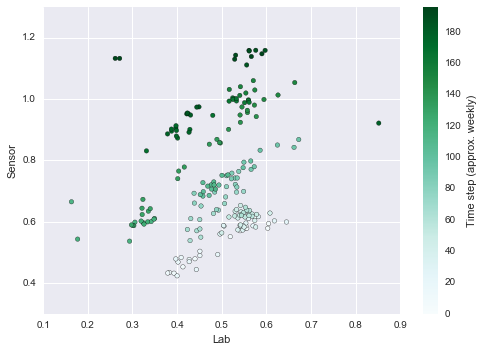

In [10]:
# Join
df = pd.merge(lab_df[['254nm',]], sen_df[[254,]], how='left', left_index=True, right_index=True)
df.columns = ['Lab', 'Sensor']

# Drop any no data values
df.dropna(how='any', inplace=True)

# Reset the index, so the colours will reflect the sample number
# from 2012 onwards
df.reset_index(inplace=True)

# Plot
pts = plt.scatter(df['Lab'], df['Sensor'], c=range(len(df)), cmap='BuGn')
plt.xlabel('Lab')
plt.ylabel('Sensor')
a = plt.colorbar(pts)
a.set_label('Time step (approx. weekly)')
plt.show()

It's pretty obvious that the relationship here drifts through time. It would be interesting to know whether this drift is more exaggerated for particular wavelengths, or whether it's an issue across the whole absorbance specturm. As a rough indicator, let's plot each trace colour-coded according to wavelength.

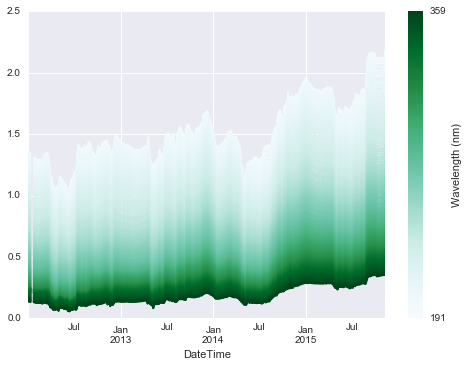

In [11]:
# Resample sensor data to daily to reduce data volume
sen_day = sen_df.resample('D').mean()

# Plot
sen_day.plot(colormap='BuGn', legend=False)

# Add colourbar
sm = plt.cm.ScalarMappable(cmap='BuGn')
sm._A = []
cbar = plt.colorbar(sm, ticks=[0, 1])
cbar.ax.set_yticklabels([sen_day.columns[0], sen_day.columns[-1]])
cbar.set_label('Wavelength (nm)')
plt.show()

Looking at this, it seems as though **shorter wavelengths (higher frequencies) are drifting the most**. It would be helpful to know a bit more about the instrument taking these measurments to see if this pattern has an obvious explanation. I still wonder about the possibility of **algal growth** on the probe absorbing particular wavelengths. Kari's idea of the **light source becoming old** is also plausible, as we might expect this to affect the high energy (i.e. high frequency) part of the spectrum the most.

## 2. Detrending

This section investigates some simple options for detrending. We'll start by focusing on the series for 254 nm, which is plotted above. If I can identify a working method, I can then apply it more widely.

Let's begin with some simple **polymomial fitting**.

In [12]:
# Extract the hourly data for this wavelength and fill
# any data gaps
df = sen_df[[254,]].interpolate(kind='linear')

# Add an integer index for fitting the poly
df['idx'] = range(len(df))

# Try 3rd degree poly
poly_pars = np.polyfit(df['idx'], df[254], 3)
p = np.poly1d(poly_pars)

# Get poly for plotting
df['poly_fit3'] = p(df['idx'])

# If we assume the lab and sensor series are roughly co-incident at 
# the start, we don't need to subtract the constant in the poly,
# so set to 0
poly_pars[-1] = 0
p = np.poly1d(poly_pars)
df['correction'] = p(df['idx'])

# Subtract correction
df['detrended'] = df[254] - df['correction']
del df['idx']

# Plot
df.plot()
mpld3.display()

How does the corrected series compare to the lab data?

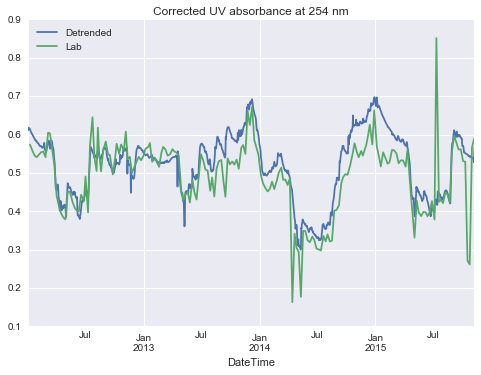

In [13]:
# Extract data for 254 nm
df_day = df[['detrended',]].resample('D').mean()
lab_day = lab_df[['254nm',]].resample('D').mean()

# Join based on datetime, rename and interpolate
df = pd.merge(df_day, lab_day, how='left', left_index=True, right_index=True)
df.columns = ['Detrended', 'Lab']
df.interpolate(kind='linear', inplace=True)

# Plot
df.plot()
plt.title('Corrected UV absorbance at 254 nm')
plt.show()

This looks promising, and it would be easy to apply this method to the series for all wavelengths. It needs checking carefully though, as it assumes that there are **no long term trends in the lab data**. I'll look into this further when I get the chance.